In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from tqdm import tqdm
import timm
import torchattacks
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import detectors

In [2]:
DATASET_SUBSET = True
DATASET_SUBSET_SIZE = 100

In [3]:
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std =  (0.2023, 0.1994, 0.201)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std)
])

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

if DATASET_SUBSET:
    train_subset_indices = list(range(0, DATASET_SUBSET_SIZE))
    test_subset_indices = list(range(0, DATASET_SUBSET_SIZE // 2))
    trainset = torch.utils.data.Subset(trainset, train_subset_indices)
    testset = torch.utils.data.Subset(testset, test_subset_indices)

print(f'Train set size: {len(trainset)}')
print(f'Test set size: {len(testset)}')

Files already downloaded and verified
Files already downloaded and verified
Train set size: 100
Test set size: 50


In [4]:
batch_size = 10
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

print(f'Train loader batches: {len(trainloader)}')
print(f'Test loader batches: {len(testloader)}')

Train loader batches: 10
Test loader batches: 5


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
def evaluate_attack(attack, dataloader):
    model.eval()
    correct = 0
    total = 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        if attack:
            adv_inputs = attack(inputs, labels)
        else:
            adv_inputs = inputs

        outputs = model(adv_inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [7]:
def visualize(dataset, attack=None):
    model.eval()
    
    for img, label in dataset:
        img = img.unsqueeze(0).cuda()
        label = torch.tensor([label]).cuda()

        clean_outputs = model(img)
        _, clean_preds = torch.max(clean_outputs, 1)

        adv_images = attack(img, label) if attack is not None else img
        adv_outputs = model(adv_images)
        _, adv_preds = torch.max(adv_outputs, 1)

        mask = adv_images - img

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        fig.subplots_adjust(wspace=0.5)

        axes[0].imshow(np.transpose(denormalize(img[0]).cpu().numpy(), (1, 2, 0)))
        axes[0].set_title(f"Clean Image\nPred: {clean_preds[0].item()}\nTrue: {label.item()}")
        axes[0].axis('off')

        axes[1].imshow(np.transpose(denormalize(adv_images[0]).cpu().numpy(), (1, 2, 0)))
        axes[1].set_title(f"Adversarial Image\nPred: {adv_preds[0].item()}")
        axes[1].axis('off')

        axes[2].imshow(np.transpose(denormalize(mask[0]).cpu().numpy(), (1, 2, 0)))
        axes[2].set_title("Perturbation (Mask)")
        axes[2].axis('off')

        plt.show()

In [8]:
def denormalize(img):
    img_normalized = img.clone()
    for c in range(3):
        img_normalized[c] = img[c] * norm_std[c] + norm_mean[c]
    img_normalized = torch.clamp(img_normalized, 0, 1)
    return img_normalized

In [9]:
model = timm.create_model('resnet18_cifar10', pretrained=True).to(device)

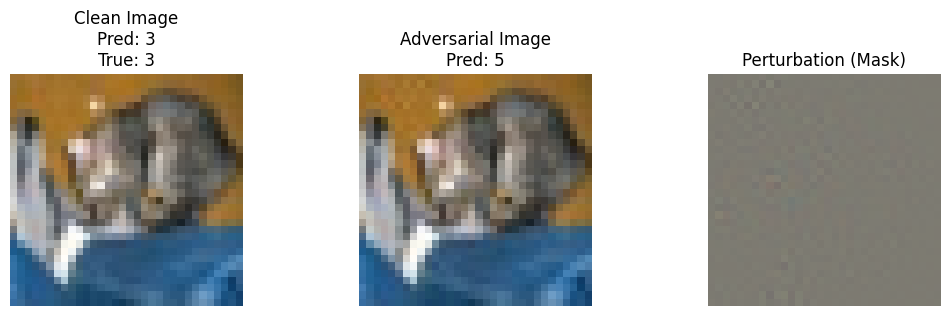

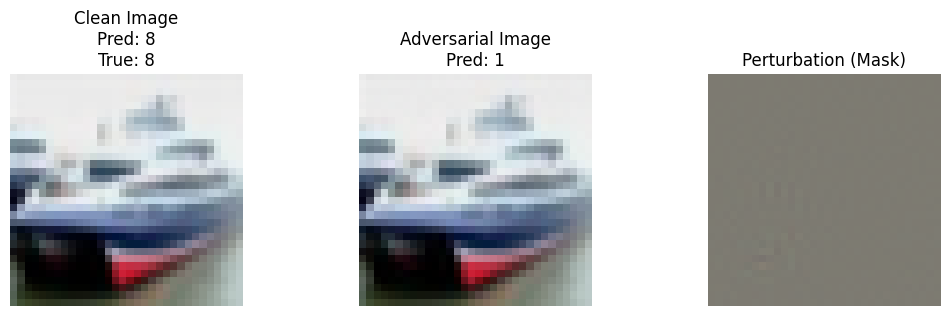

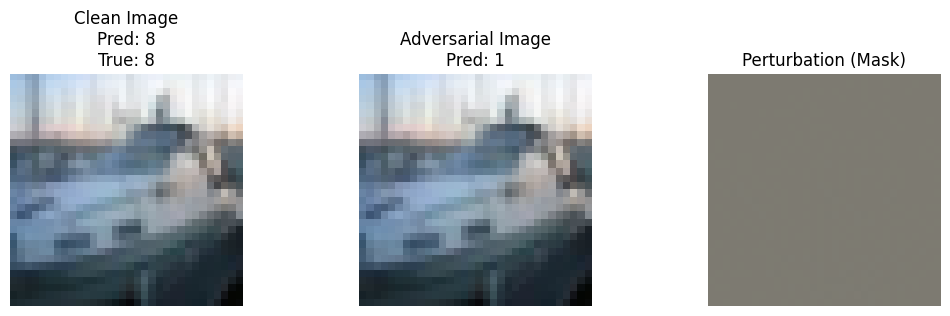

In [10]:
DeepFool = torchattacks.DeepFool(model, steps=50, overshoot=0.02)
DeepFool.set_normalization_used(mean=norm_mean, std=norm_std)
visualize([testset[i] for i in range(0, 3)], attack=DeepFool)

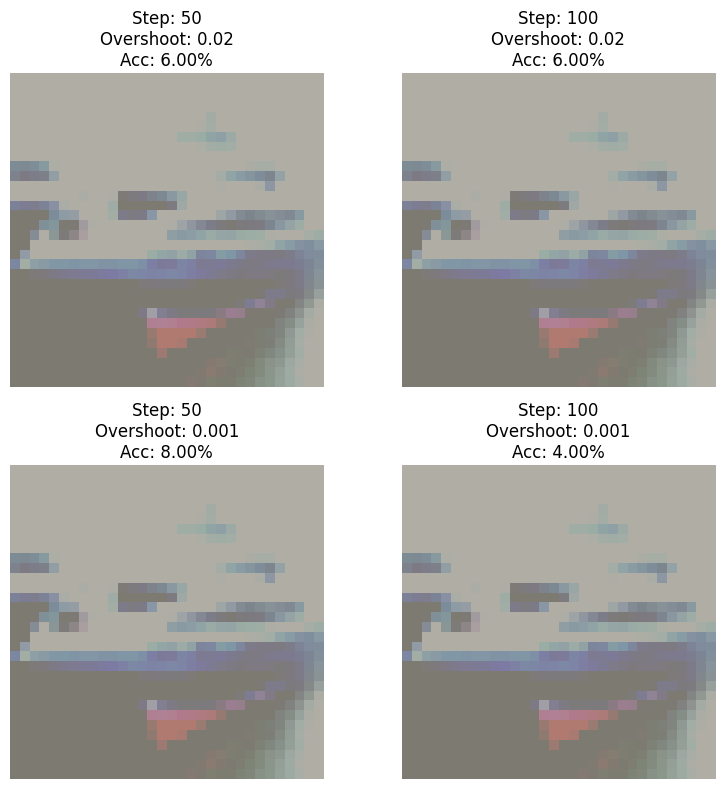

In [11]:
def visualize_grid(dataset, model, attack_fn, steps, overshoots, evaluate_fn):
    model.eval()
    grid_rows = len(overshoots)
    grid_cols = len(steps)
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))

    for row, overshoot in enumerate(overshoots):
        for col, step in enumerate(steps):

            attack = attack_fn(model, steps=step, overshoot=overshoot)


            accuracy = evaluate_fn(attack, testloader)       

            img, label = dataset[1]
            img = img.unsqueeze(0).cuda()
            label = torch.tensor([label]).cuda()
            adv_img = attack(img, label)
        
            mask = adv_img - img

            axes[row, col].imshow(np.transpose(denormalize(adv_img[0]).cpu().numpy(), (1, 2, 0)))
            axes[row, col].axis('off')
            axes[row, col].set_title(f"Step: {step}\nOvershoot: {overshoot}\nAcc: {accuracy:.2f}%")
    plt.tight_layout()
    plt.show()



# steps = (50, 100, 200, 500, 1000)
# overshoots = (0.02, 0.001, 0.05, 0.1, 0.2, 0.5, 1)

steps = (50, 100)
overshoots = (0.02, 0.001)


sampled_dataset = [testset[i] for i in range(0, 2)]

visualize_grid(
    sampled_dataset, 
    model, 
    torchattacks.DeepFool,
    steps, 
    overshoots, 
    evaluate_attack
)